## Multi-glacier-model SPEI analysis
This notebook will read in SPEI for GRDC major river basins, including the effect of glacial runoff.  We compare the glacial runoff computed by three global glacier models.

For now, the notebook reads in only the preliminary dataset -- ten example basins, not global coverage.

10 Jul 2023 | EHU

Edits:
- 5 Oct 2023: replace preliminary data with full dataset


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.patches import Rectangle
import gSPEI as gSPEI

In [2]:
## Define the filepath -- new data is streamed from Google Drive
fpath = '/Volumes/GoogleDrive/My Drive/Runoff-intercomparison/SPEI_computed/Results-scoats-20230901/'

## Settings in filenames -- slightly different model names and scenarios
gmodels = ['GloGEM', 'PyGEM', 'OGGM']
integration_times = np.arange(3, 28, 4) # all SPEI integration times used
modelnames_provis = ['BCC.BCC-CSM2-MR',
                    'MPI-M.MPI-ESM1-2-HR',
                    'MRI.MRI-ESM2-0',
                    'NCAR.CESM2-WACCM',
                    'NCC.NorESM2-MM'] 
scenarios = ['Ssp2p6', 'Ssp4p5', 'Ssp7p0', 'Ssp8p5'] # climate scenarios
cases = ['NRunoff', 'WRunoff', 'diff'] # inclusion of glacier runoff

yrs = np.linspace(1900, 2101, num=2412) # time interval over which we have data

In [3]:
## Basins in the order they are written
basins_all = {'RHINE':'6242', 'RHONE':'6243','PO':'6241', 'DANUBE':'6202', 'TITICACA':'3912', 'SANTA':'3425', 
            'OCONA':'3418', 'MAJES':'3416', 'MAGDALENA':'3227', 'AMAZON':'3203', 'YELCHO':'3429', 
            'VALDIVIA':'3428', 'SERRANO':'3426', 'RAPEL':'3423', 'PUELO':'3422', 'PASCUA':'3420', 
            'PALENA':'3419', 'HUASCO':'3412', 'COPIAPO':'3409', 'CISNES':'3408', 'BIOBIO':'3405', 'BAKER':'3404',
            'AZOPARDO':'3403', 'AISEN':'3401', 'SANTA CRUZ':'3244', 'NEGRO':'3232', 'COLORADO':'3212', 
            'CHICO':'3209', 'TORNEALVEN':'6255', 'THJORSA':'6254', 'OLFUSA':'6237', 'LULEALVEN':'6227', 
            'KUBAN':'6223', 'KALIXALVEN':'6219', 'GLOMAA':'6213', 'DRAMSELVA':'6209', 'SVARTA':'6110', 
            'LAGARFLJOT':'6104', 'JOKULSA A FJOLLUM':'6101', 'CLUTHA':'5406', 'YUKON':'4435', 'TAKU':'4431', 
             'SUSITNA':'4430','STIKINE':'4428', 'SKEENA':'4427','SKAGIT':'4426','NUSHAGAK':'4418','NASS':'4416',
            'KUSKOKWIM':'4414','FRASER':'4410', 'COPPER':'4408', 'COLUMBIA':'4406', 'ALSEK':'4401', 'NELSON':'4125', 
              'MACKENZIE':'4123','COLVILLE':'4110', 'YSYK-KOL':'2919', 'UVS NUUR':'2918', 'TARIM HE':'2914', 
              'TALAS':'2913', 'LAKE BALKHASH':'2910','HAR US NUUR':'2909', 'CHUY':'2905', 'ARAL SEA':'2902', 
              'YELLOW RIVER':'2434', 'MEKONG':'2421', 'KAMCHATKA':'2413', 'SALWEEN':'2319', 'IRRAWADDY':'2310', 
              'INDUS':'2309', 'GANGES':'2306','BRAHMAPUTRA':'2302', 'OB':'2108', 'INDIGIRKA':'2103','YANGTZE' : '2433'}

In [10]:
## Make an array to guarantee the order will remain intact
basin_names = basins_all.keys() ## keys actually remember insertion order as of Python 3.7, wow modern

In [4]:
itime = integration_times[0] # select timescale of integration. [0] is 3 months, used in manuscript.
scen = scenarios[0] # choose which SSP to load

## Create terrible nested dictionary until we overhaul the rest of the structure
SPEI_by_GEM = {g: {} for g in gmodels} ## outer organization by glacier model
for g in gmodels:
    SPEI_by_model = {m: {} for m in modelnames_provis} # create dictionary indexed by model name
    for m in modelnames_provis:
        norunoff_f_m = fpath+'NRunoff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        wrunoff_f_m = fpath+'WRunOff_{}_{}_{}_{}.txt'.format(g, itime, m, scen)
        SPEI_by_model[m]['NRunoff'] = np.loadtxt(norunoff_f_m)
        SPEI_by_model[m]['WRunoff'] = np.loadtxt(wrunoff_f_m)
        SPEI_by_model[m]['diff'] = SPEI_by_model[m]['WRunoff'] - SPEI_by_model[m]['NRunoff']
    SPEI_by_GEM[g] = SPEI_by_model

In [5]:
## Inspect - looked like some NaNs, so we spot-check a few rows
sum(np.isnan(SPEI_by_GEM['GloGEM']['BCC.BCC-CSM2-MR']['NRunoff'][9]))

12

In the original `SPEI-analysis.ipynb`, we use `gSPEI.sort_models_to_basins` to organize by basin.  Here we have a different subset of basins to analyze...so we're doin' it live.

In [11]:
import pandas as pd 

SPEI_basin_sorted_GEM_raw = {g: {} for g in gmodels}
for g in gmodels:
    SPEI_by_basin = {b: {} for b in basin_names} # create dictionary indexed by basin name
    for i, b in enumerate(basins_all):
        SPEI_by_basin[b] = {case: {} for case in cases}
        for case in cases:
            tempdict = {}
            for m in modelnames_provis:
                tempdict[m] = SPEI_by_GEM[g][m][case][i] # pull data from SPEI_by_model dicts into this new dict
            SPEI_by_basin[b][case] = pd.DataFrame.from_dict(tempdict)
    SPEI_basin_sorted_GEM_raw[g] = SPEI_by_basin

SPEI_basin_sorted_GEM = {g: {b: {} for b in basin_names} for g in gmodels}
for g in gmodels:
    for b in basin_names:
        for c in cases:
            SPEI_basin_sorted_GEM[g][b][c] = SPEI_basin_sorted_GEM_raw[g][b][c].fillna(-3) # fill negative excursions that were stored as NaNs

## Plot multi-GCM ensemble series for a given basin

First, we can plot time series of SPEI with and without glacial runoff included.  Examples of this kind of figure appear in Ultee, Coats & Mackay Figure 1.

We will use a helper function from gSPEI.py to compare running ensemble mean SPEI with no glacial runoff (orange) versus with glacial runoff (blue).  The function can also show SPEI time series for a single basin, separated by the global climate model that produced each series.  Choose the basin by its name from the `basin_names` list, above. 

By default, we plot a running mean so that long-term trends can be more easily seen.  If you prefer, you can adjust `window` to show time series with less smoothing (shorter rolling-mean windows).  You can also turn on or off the option to see single-GCM series along with the ensembles.

In [12]:
example_b = 'RHONE' # name of basin to examine, selected from basin_names above
win = 15 # window in years over which to calculate the running mean
plot_single_models = False # choose whether to see individual GCMs plotted over ensembles

In [13]:
## Compute multi-GCM ensemble means and quartiles
## Plot for single example GEM for now
example_GEM = 'GloGEM'
r_w = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'WRunoff').rolling(window=12*win).mean()
r_n = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'NRunoff').rolling(window=12*win).mean()
rm = SPEI_by_basin[example_b]['WRunoff'].rolling(window=12*win, axis=0).mean()
rm_q1 = rm.quantile(q=0.25, axis=1)
rm_q3 = rm.quantile(q=0.75, axis=1)
rm_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*win, axis=0).mean()
rm_q1_n = rm_n.quantile(q=0.25, axis=1)
rm_q3_n = rm_n.quantile(q=0.75, axis=1)

single_models_w = [SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]
single_models_n = [SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]

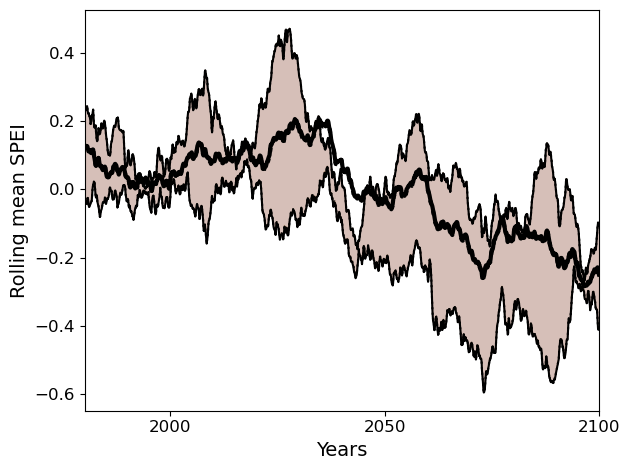

In [14]:
colors_w = cm.get_cmap('Blues')(np.linspace(0.2, 1, num=len(modelnames_provis)))
colors_n = cm.get_cmap('Wistia')(np.linspace(0.2, 1, num=len(modelnames_provis)))
fig, ax = plt.subplots()
ax.plot(yrs, r_w, 'k', linewidth=3.0)
ax.plot(yrs, rm_q1, 'k')
ax.plot(yrs, rm_q3, 'k')
ax.plot(yrs, r_n, 'k', linewidth=3.0, ls=':')
ax.plot(yrs, rm_q1_n, 'k', ls=':')
ax.plot(yrs, rm_q3_n, 'k', ls=':')
if plot_single_models:
    for i in range(len(modelnames_provis)):
        ax.plot(yrs, single_models_w[i], color=colors_w[i], alpha=0.5)
        ax.plot(yrs, single_models_n[i], color=colors_n[i], alpha=0.5)
ax.fill_between(yrs, rm_q1, rm_q3, color='DarkBlue', alpha=0.2)
ax.fill_between(yrs, rm_q1_n, rm_q3_n, color='DarkOrange', alpha=0.2)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks([2000, 2050, 2100])
ax.set_xlim(1980, 2100)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Rolling mean SPEI', fontsize=14)
plt.tight_layout()

Now that we know this appears to be working for a single GEM, let's add the others and compare.

GloGEM
PyGEM
OGGM


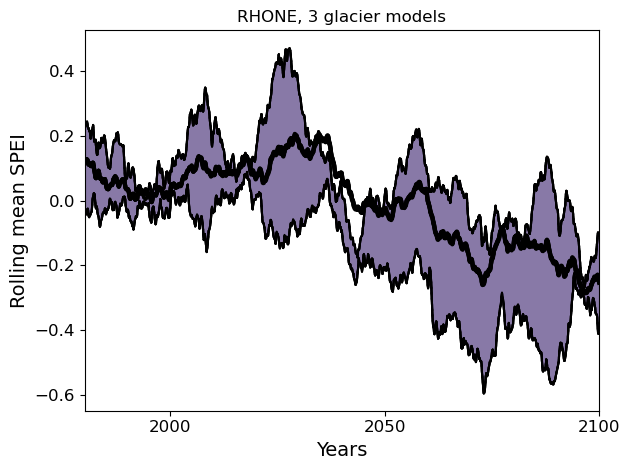

In [15]:
## Compute multi-GCM ensemble means and quartiles
## Plot for single example GEM for now
colors_n = cm.get_cmap('Wistia')(np.linspace(0.2, 1, num=len(modelnames_provis)))
colormaps_w = {'GloGEM': 'Greens', 'PyGEM': 'Purples', 'OGGM': 'Blues'} ## match the colors Finn used for runoff

fig, ax = plt.subplots()
for g in gmodels:
    example_GEM = g
    print(g)
    colors_w = cm.get_cmap(colormaps_w[g])(np.linspace(0.2, 1, num=len(modelnames_provis)))
    r_w = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'WRunoff').rolling(window=12*win).mean()
    r_n = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'NRunoff').rolling(window=12*win).mean()
    rm = SPEI_by_basin[example_b]['WRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1 = rm.quantile(q=0.25, axis=1)
    rm_q3 = rm.quantile(q=0.75, axis=1)
    rm_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1_n = rm_n.quantile(q=0.25, axis=1)
    rm_q3_n = rm_n.quantile(q=0.75, axis=1)
    # rm_q1_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.25, axis=1)
    # rm_q3_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.75, axis=1)

    single_models_w = [SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]
    single_models_n = [SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]



    ax.plot(yrs, r_w, 'k', linewidth=3.0)
    ax.plot(yrs, rm_q1, 'k')
    ax.plot(yrs, rm_q3, 'k')
    ax.fill_between(yrs, rm_q1, rm_q3, color='DarkBlue', alpha=0.2)
    if g == 'GloGEM': ## plot these only once, as they should all be the same
        ax.plot(yrs, r_n, 'k', linewidth=3.0, ls=':')
        ax.plot(yrs, rm_q1_n, 'k', ls=':')
        ax.plot(yrs, rm_q3_n, 'k', ls=':')
        ax.fill_between(yrs, rm_q1_n, rm_q3_n, color='DarkOrange', alpha=0.2)
    if plot_single_models:
        for i in range(len(modelnames_provis)):
            ax.plot(yrs, single_models_w[i], color=colors_w[i], alpha=0.5)
            ax.plot(yrs, single_models_n[i], color=colors_n[i], alpha=0.5)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks([2000, 2050, 2100])
ax.set_xlim(1980, 2100)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Rolling mean SPEI', fontsize=14)
ax.set(title='{}, 3 glacier models'.format(example_b))
plt.tight_layout()

In [18]:
for m in modelnames_provis:
    print(m)
    print(np.nanmean(SPEI_basin_sorted_GEM['PyGEM'][example_b]['WRunoff'][m].rolling(window=12*win).mean()-
                                    SPEI_basin_sorted_GEM['OGGM'][example_b]['WRunoff'][m].rolling(window=12*win).mean()))

BCC.BCC-CSM2-MR
0.0016162165984724064
MPI-M.MPI-ESM1-2-HR
0.0016357395865800846
MRI.MRI-ESM2-0
0.0016432775327287637
NCAR.CESM2-WACCM
0.0020176990339229772
NCC.NorESM2-MM
0.00311245313536846


Hah!  In the Rhone basin, these differences appear very small indeed.  This is encouraging.  Let's check a South American basin where there might be more difference? 

In [38]:
example_b = 'INDUS' # name of basin to examine, selected from basin_names above
win = 15 # window in years over which to calculate the running mean
plot_single_models = False # choose whether to see individual GCMs plotted over ensembles

GloGEM
PyGEM
OGGM


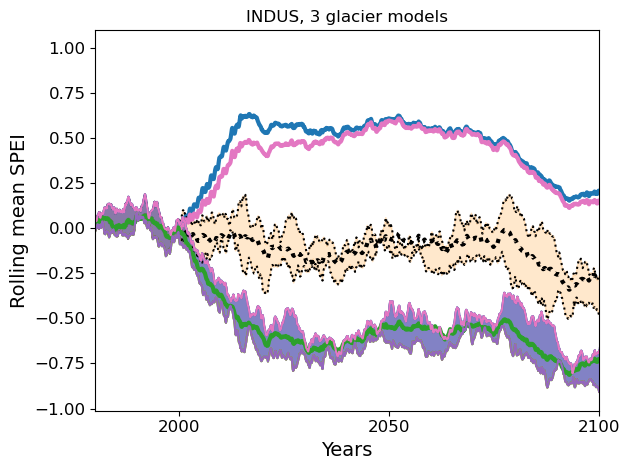

In [40]:
## Compute multi-GCM ensemble means and quartiles
## Plot for single example GEM for now
colors_n = cm.get_cmap('Wistia')(np.linspace(0.2, 1, num=len(modelnames_provis)))
colormaps_w = {'GloGEM': 'Greens', 'PyGEM': 'Purples', 'OGGM': 'Blues'} ## match the colors Finn used for runoff

fig, ax = plt.subplots()
for g in gmodels:
    example_GEM = g
    print(g)
    colors_w = cm.get_cmap(colormaps_w[g])(np.linspace(0.2, 1, num=len(modelnames_provis)))
    r_w = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'WRunoff').rolling(window=12*win).mean()
    r_n = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'NRunoff').rolling(window=12*win).mean()
    rm = SPEI_by_basin[example_b]['WRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1 = rm.quantile(q=0.25, axis=1)
    rm_q3 = rm.quantile(q=0.75, axis=1)
    rm_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1_n = rm_n.quantile(q=0.25, axis=1)
    rm_q3_n = rm_n.quantile(q=0.75, axis=1)
    # rm_q1_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.25, axis=1)
    # rm_q3_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.75, axis=1)

    single_models_w = [SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]
    single_models_n = [SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]



    # ax.plot(yrs, r_w, 'k', linewidth=3.0)
    # ax.plot(yrs, rm_q1, 'k')
    # ax.plot(yrs, rm_q3, 'k')
    ax.plot(yrs, r_w, cm.get_cmap(colormaps_w[g])(1.0), linewidth=3.0) ## Tried to plot color-coding by GEM, but it looks weird.
    ax.plot(yrs, rm_q1, cm.get_cmap(colormaps_w[g])(1.0))
    ax.plot(yrs, rm_q3, cm.get_cmap(colormaps_w[g])(1.0))
    ax.fill_between(yrs, rm_q1, rm_q3, color='DarkBlue', alpha=0.2)
    if g == 'GloGEM': ## plot these only once, as they should all be the same
        ax.plot(yrs, r_n, 'k', linewidth=3.0, ls=':')
        ax.plot(yrs, rm_q1_n, 'k', ls=':')
        ax.plot(yrs, rm_q3_n, 'k', ls=':')
        ax.fill_between(yrs, rm_q1_n, rm_q3_n, color='DarkOrange', alpha=0.2)
    if plot_single_models:
        for i in range(len(modelnames_provis)):
            ax.plot(yrs, single_models_w[i], color=colors_w[i], alpha=0.5)
            ax.plot(yrs, single_models_n[i], color=colors_n[i], alpha=0.5)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks([2000, 2050, 2100])
ax.set_xlim(1980, 2100)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Rolling mean SPEI', fontsize=14)
ax.set(title='{}, 3 glacier models'.format(example_b))
plt.tight_layout()

In [21]:
for m in modelnames_provis:
    print(m)
    print(np.nanmax(SPEI_basin_sorted_GEM['PyGEM'][example_b]['WRunoff'][m]-
                                    SPEI_basin_sorted_GEM['OGGM'][example_b]['WRunoff'][m]))

BCC.BCC-CSM2-MR
0.1521503999999998
MPI-M.MPI-ESM1-2-HR
0.07136199999999993
MRI.MRI-ESM2-0
0.39432529999999977
NCAR.CESM2-WACCM
0.07136199999999993
NCC.NorESM2-MM
0.2128283000000002


Santa also looks the same.  Let's check all we have available.

## Compare multi-glacier-model SPEI values for all 75 example basins
Multi-panel plot: 5 across, 2 rows, all example basins.

Text(0.02, 0.5, 'Rolling mean SPEI')

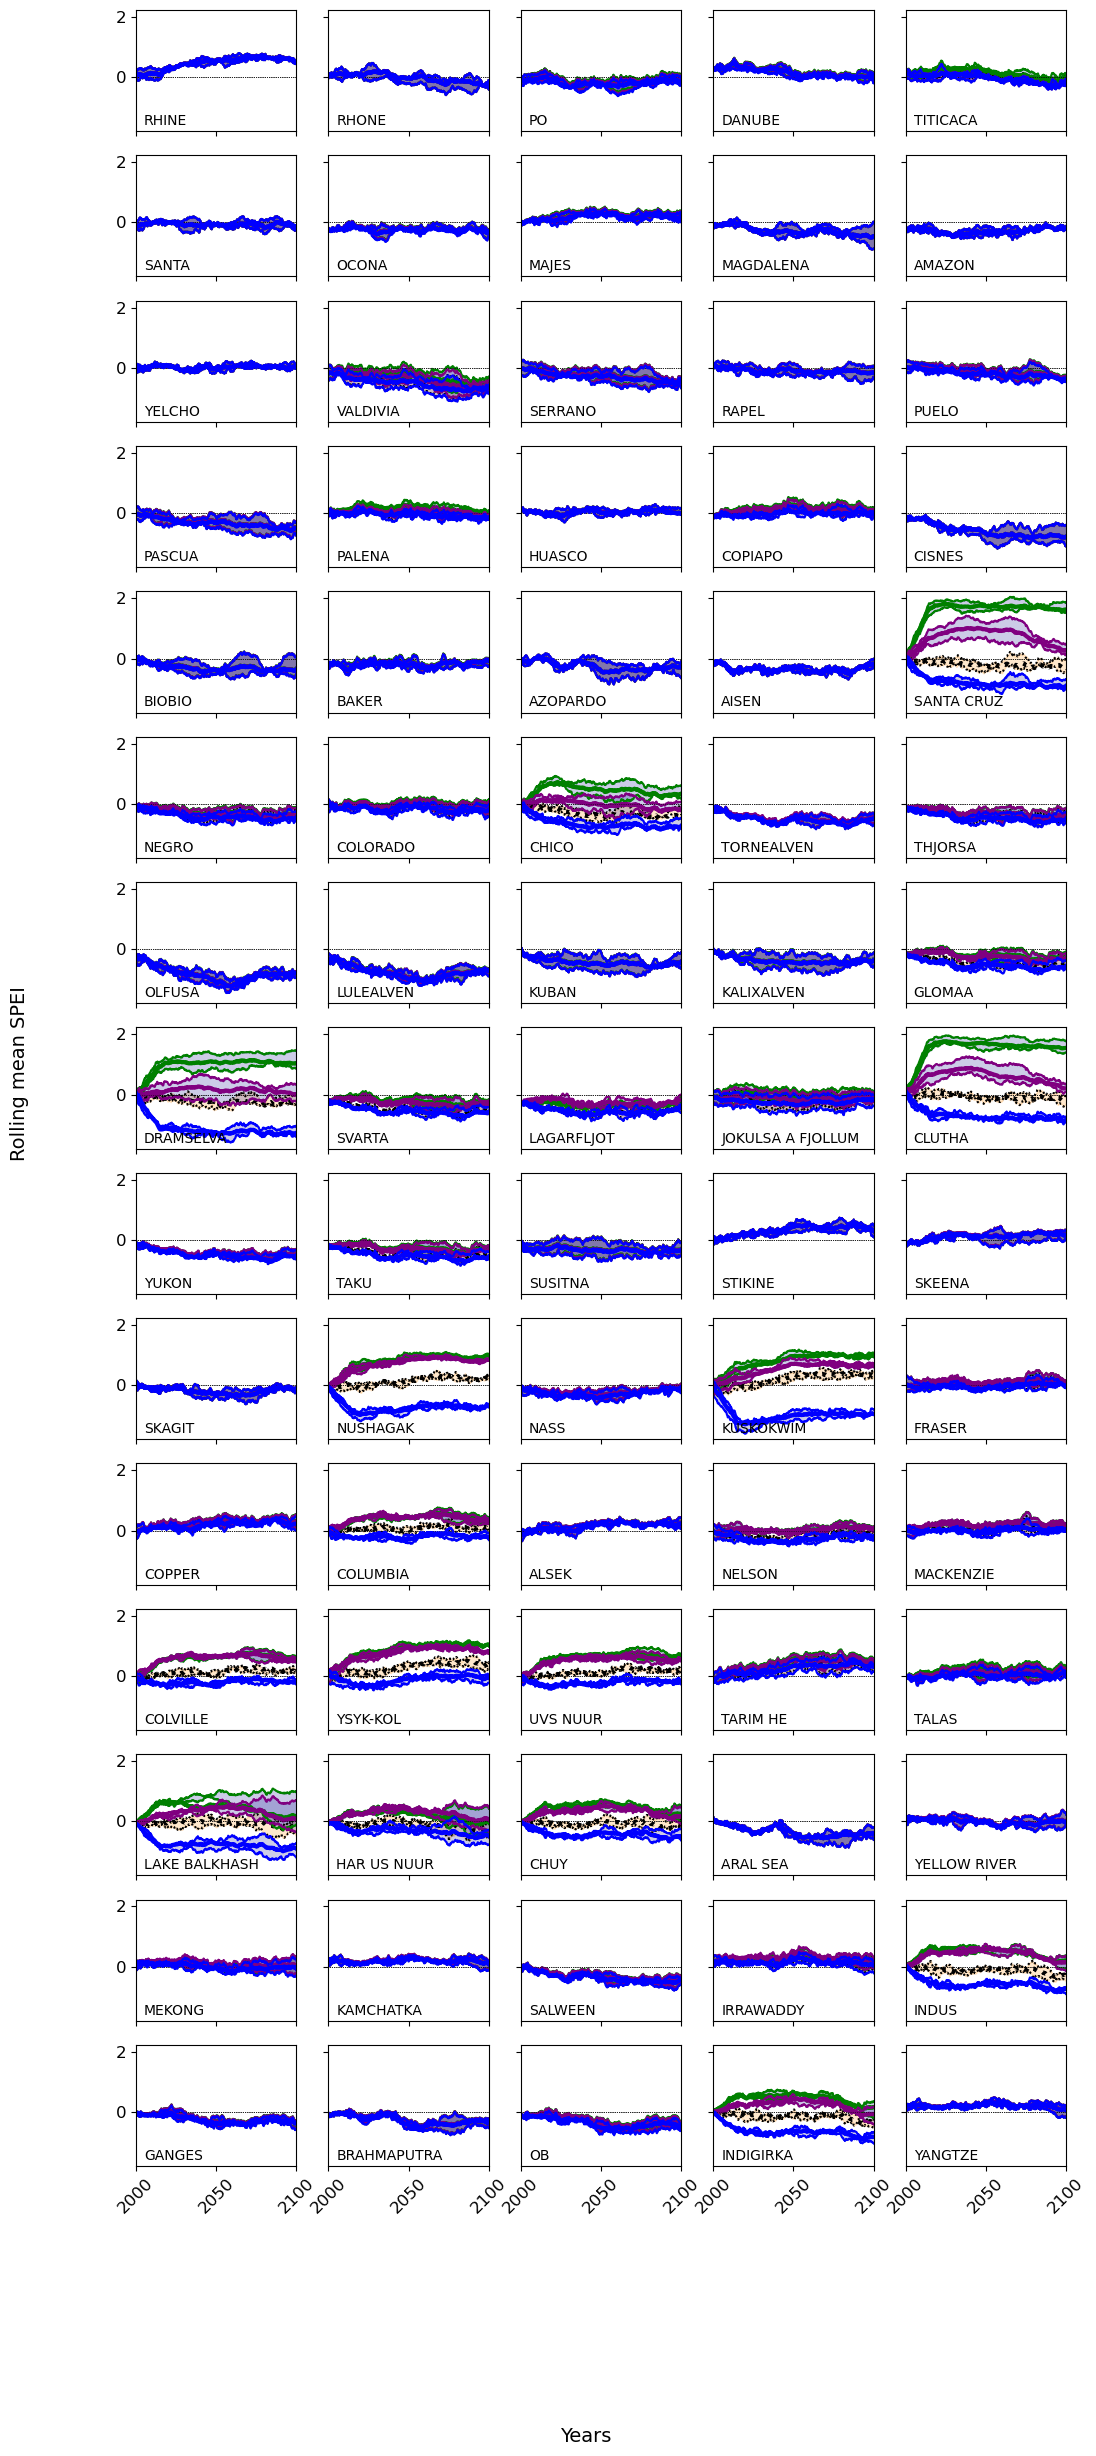

In [52]:
example_color_w_glogem='Green'
example_color_w_pygem='Purple'
example_color_w_oggm='Blue'

example_colors_w = {'GloGEM': example_color_w_glogem,
                    'PyGEM': example_color_w_pygem,
                    'OGGM': example_color_w_oggm}

fig, axs = plt.subplots(15,5, figsize=(12,28), sharey=True, sharex=True)
for i,b in enumerate(basin_names):
    ax = axs.ravel()[i]
    example_b=b
    for g in gmodels:
        example_GEM = g
        # print(g)
        colors_w = cm.get_cmap(colormaps_w[g])(np.linspace(0.2, 1, num=len(modelnames_provis)))
        r_w = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'WRunoff').rolling(window=12*win).mean()
        r_n = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'NRunoff').rolling(window=12*win).mean()
        rm = SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'].rolling(window=12*win, axis=0).mean()
        rm_q1 = rm.quantile(q=0.25, axis=1)
        rm_q3 = rm.quantile(q=0.75, axis=1)
        rm_n = SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'].rolling(window=12*win, axis=0).mean()
        rm_q1_n = rm_n.quantile(q=0.25, axis=1)
        rm_q3_n = rm_n.quantile(q=0.75, axis=1)
        # rm_q1_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*win, axis=0).quantile(quantile=0.25, axis=1)
        # rm_q3_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*win, axis=0).quantile(quantile=0.75, axis=1)

        single_models_w = [SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]
        single_models_n = [SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]

        ax.axhline(y=0, color='k', ls=':', lw=0.5)
        if g == 'GloGEM': ## plot these only once, as they should all be the same
            ax.plot(yrs, r_n, 'k', linewidth=3.0, ls=':')
            ax.plot(yrs, rm_q1_n, 'k', ls=':')
            ax.plot(yrs, rm_q3_n, 'k', ls=':')
            ax.fill_between(yrs, rm_q1_n, rm_q3_n, color='DarkOrange', alpha=0.2)
        
        # ax.plot(yrs, r_w, 'k', linewidth=3.0)
        # ax.plot(yrs, rm_q1, 'k')
        # ax.plot(yrs, rm_q3, 'k')
        ax.plot(yrs, r_w, example_colors_w[g], linewidth=3.0, label=g) ## Color-code by GEM
        ax.plot(yrs, rm_q1, example_colors_w[g])
        ax.plot(yrs, rm_q3, example_colors_w[g])
        ax.fill_between(yrs, rm_q1, rm_q3, color='DarkBlue', alpha=0.2)

        if plot_single_models:
            for i in range(len(modelnames_provis)):
                ax.plot(yrs, single_models_w[i], color=colors_w[i], alpha=0.5)
                ax.plot(yrs, single_models_n[i], color=colors_n[i], alpha=0.5)
    ax.tick_params(axis='both', labelsize=12)
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xticks([2000, 2050, 2100])
    ax.set_xlim(2000, 2100)
    # ax.set_xlabel('Years', fontsize=14)
    # ax.set_ylabel('Rolling mean SPEI', fontsize=14)
    ax.text(0.05, 0.05, example_b, transform=ax.transAxes) 
    # ax.set(title='{}, 3 glacier models'.format(example_b))
    # plt.tight_layout()
fig.supxlabel('Years', fontsize=14)
fig.supylabel('Rolling mean SPEI', fontsize=14)

## Check frequency and severity metrics
The rolling mean SPEI series look very similar per glacier model.  Is the same true for the frequency and severity metrics we previously analysed?

Below modified from `SPEI-analysis.ipynb`.

We identify droughts as negative excursions in SPEI reaching at least -1.  Below, we use a helper function from gSPEI to mark where droughts occur, count how many occur over a time period, and find their average severity.

In [27]:
example_basin='RHONE'
example_model=modelnames_provis[0] #show time series from a single GCM for clarity
example_period = (2070,2100)
example_series = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['NRunoff'][example_model]

droughts = gSPEI.find_droughts(example_series, threshold=-1, 
                               period=example_period)
drought_mask = np.full(np.shape(yrs), fill_value=False)
for k in droughts.keys():
    for n in range(k-len(droughts[k]), k+1):
        drought_mask[n] = True

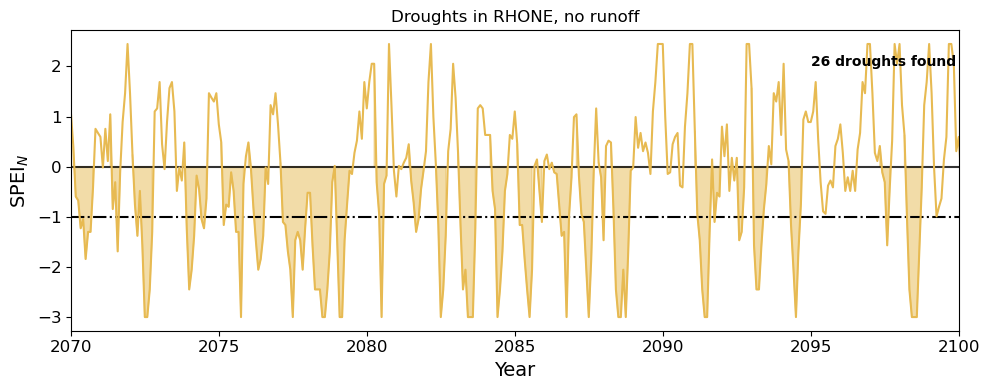

In [30]:
## Plotting
example_color=cm.get_cmap('tab20b')(10)
fig, ax = plt.subplots(figsize=(10,4), tight_layout=True)
ax.axhline(y=0, color='k', alpha=0.8)
ax.axhline(y=-1, ls='-.', color='k')
ax.plot(yrs, example_series, color=example_color)
ax.fill_between(yrs, y1=0, y2=example_series, where=drought_mask, 
                alpha=0.5, color=example_color)
ax.annotate('{} droughts found'.format(len(droughts)), xy=(2095,2),
            fontweight='bold')
ax.set(xlim=example_period)
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel(r'SPEI$_N$', fontsize=14)
ax.set_title('Droughts in {}, no runoff'.format(example_basin))
plt.show()

We can also compare the droughts found for the same example basin and model, with versus without glacial runoff.

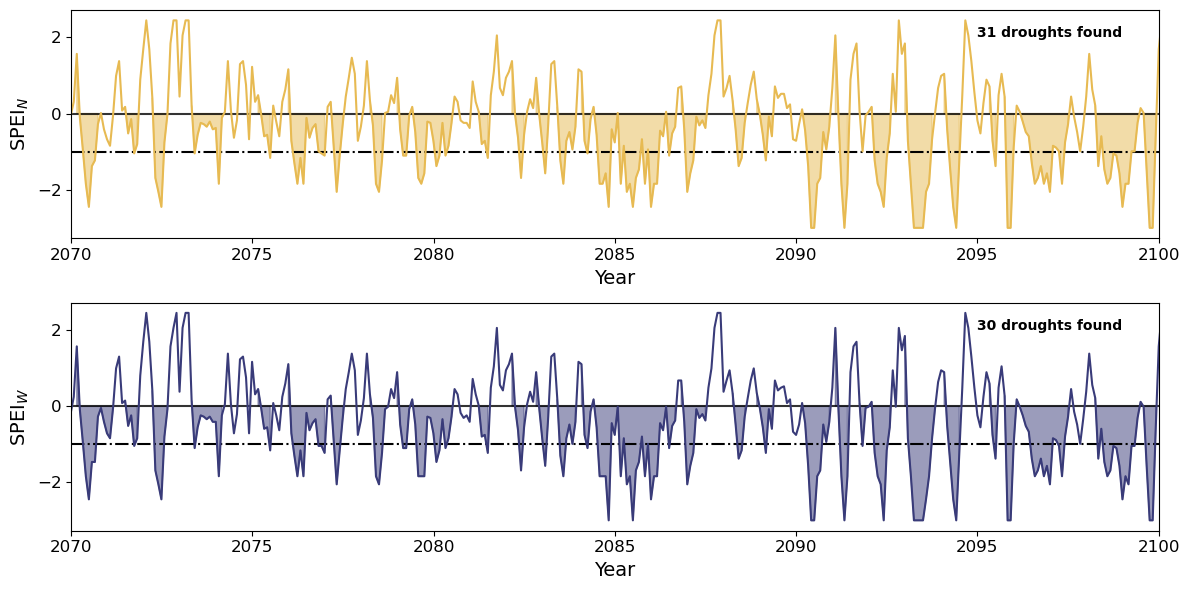

In [95]:
example_series_n = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['NRunoff'][example_model]
example_series_w = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['WRunoff'][example_model]

example_color_n=cm.get_cmap('tab20b')(10)
example_color_w=cm.get_cmap('tab20b')(0)

droughts_n = gSPEI.find_droughts(example_series_n, threshold=-1, 
                               period=example_period)
drought_mask_n = np.full(np.shape(yrs), fill_value=False)
for k in droughts_n.keys():
    for n in range(k-len(droughts_n[k]), k+1):
        drought_mask_n[n] = True
droughts_w = gSPEI.find_droughts(example_series_w, threshold=-1, 
                               period=example_period)
drought_mask_w = np.full(np.shape(yrs), fill_value=False)
for k in droughts_w.keys():
    for n in range(k-len(droughts_w[k]), k+1):
        drought_mask_w[n] = True
        
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), tight_layout=True)
ax1.axhline(y=0, color='k', alpha=0.8)
ax1.axhline(y=-1, ls='-.', color='k')
ax1.plot(yrs, example_series_n, color=example_color_n)
ax1.fill_between(yrs, y1=0, y2=example_series_n, where=drought_mask_n, 
                alpha=0.5, color=example_color_n)
ax1.annotate('{} droughts found'.format(len(droughts_n)), xy=(2095,2),
            fontweight='bold')
ax1.set(xlim=example_period, yticks=(-2, 0, 2))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel(r'SPEI$_N$', fontsize=14)

ax2.axhline(y=0, color='k', alpha=0.8)
ax2.axhline(y=-1, ls='-.', color='k')
ax2.plot(yrs, example_series_w, color=example_color_w)
ax2.fill_between(yrs, y1=0, y2=example_series_w, where=drought_mask_w, 
                alpha=0.5, color=example_color_w)
ax2.annotate('{} droughts found'.format(len(droughts_w)), xy=(2095,2),
            fontweight='bold')
ax2.set(xlim=example_period, yticks=(-2,0,2))
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel(r'SPEI$_W$', fontsize=14)
plt.show()


For the example of the Rhone basin, all three glacier models find the same reduction in drought frequency (30 counted in SPEI_W series versus 31 in SPEI_N) at the end of the century.  Report summary stats for this case using built-in function from gSPEI?

In [106]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['GloGEM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(27.4, 27.8),
 (7.657648730579766, 7.243338689078399),
 (-9.395059682573068, -8.942383666185147)]

In [105]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['PyGEM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(27.4, 27.8),
 (7.649956422887458, 7.243338689078399),
 (-9.387709105329384, -8.942383666185147)]

In [104]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['OGGM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(27.4, 27.8),
 (7.649956422887458, 7.243338689078399),
 (-9.391719319894833, -8.942383666185147)]

These are in the format \[(mean_drtnumber_w, mean_drtnumber_n), (mean_drtdur_w, mean_drtdur_n), (mean_drtsev_w, mean_drtsev_n)\], where each statistic is computed as a multi-GCM mean.  It seems that there is a very small difference in drought severity here, but otherwise little of consequence.  Check a few other basins e.g. SANTA.

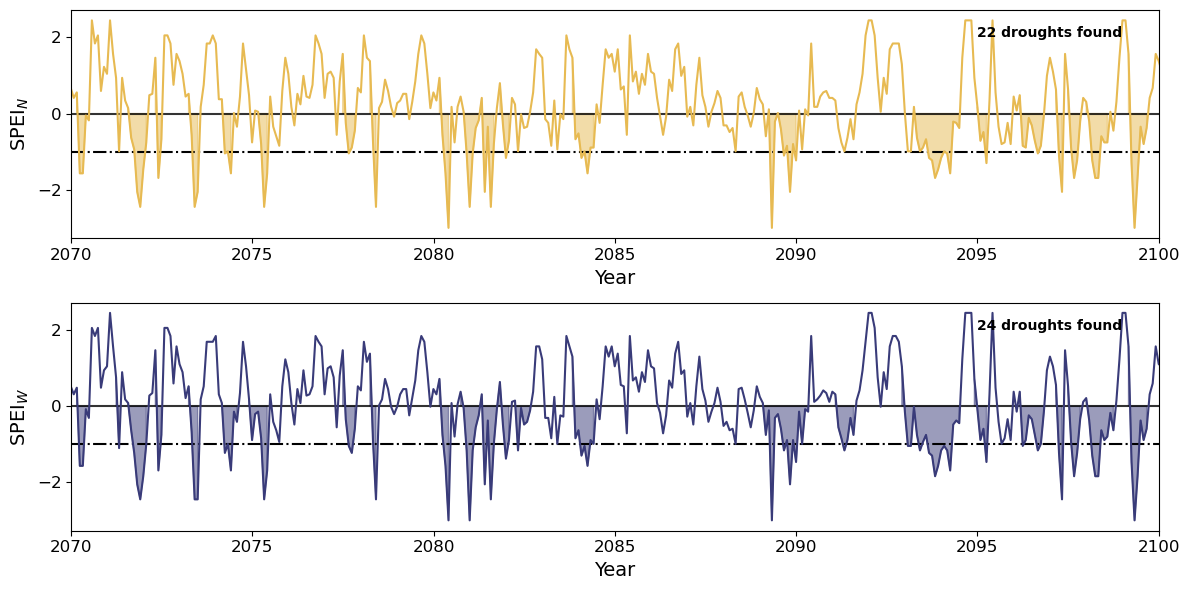

In [107]:
example_basin='SANTA'
example_series_n = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['NRunoff'][example_model]
example_series_w = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['WRunoff'][example_model]

example_color_n=cm.get_cmap('tab20b')(10)
example_color_w=cm.get_cmap('tab20b')(0)

droughts_n = gSPEI.find_droughts(example_series_n, threshold=-1, 
                               period=example_period)
drought_mask_n = np.full(np.shape(yrs), fill_value=False)
for k in droughts_n.keys():
    for n in range(k-len(droughts_n[k]), k+1):
        drought_mask_n[n] = True
droughts_w = gSPEI.find_droughts(example_series_w, threshold=-1, 
                               period=example_period)
drought_mask_w = np.full(np.shape(yrs), fill_value=False)
for k in droughts_w.keys():
    for n in range(k-len(droughts_w[k]), k+1):
        drought_mask_w[n] = True
        
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), tight_layout=True)
ax1.axhline(y=0, color='k', alpha=0.8)
ax1.axhline(y=-1, ls='-.', color='k')
ax1.plot(yrs, example_series_n, color=example_color_n)
ax1.fill_between(yrs, y1=0, y2=example_series_n, where=drought_mask_n, 
                alpha=0.5, color=example_color_n)
ax1.annotate('{} droughts found'.format(len(droughts_n)), xy=(2095,2),
            fontweight='bold')
ax1.set(xlim=example_period, yticks=(-2, 0, 2))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel(r'SPEI$_N$', fontsize=14)

ax2.axhline(y=0, color='k', alpha=0.8)
ax2.axhline(y=-1, ls='-.', color='k')
ax2.plot(yrs, example_series_w, color=example_color_w)
ax2.fill_between(yrs, y1=0, y2=example_series_w, where=drought_mask_w, 
                alpha=0.5, color=example_color_w)
ax2.annotate('{} droughts found'.format(len(droughts_w)), xy=(2095,2),
            fontweight='bold')
ax2.set(xlim=example_period, yticks=(-2,0,2))
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel(r'SPEI$_W$', fontsize=14)
plt.show()


In [108]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['GloGEM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(26.6, 25.2),
 (6.063283166109253, 5.597378828068484),
 (-7.05969073847543, -6.616787268648027)]

In [109]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['PyGEM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(26.6, 25.2),
 (6.063283166109253, 5.597378828068484),
 (-7.059948065747224, -6.616787268648027)]

In [110]:
gSPEI.basin_summary_stats(SPEI_basin_sorted_GEM['OGGM'], example_basin, modelnames_provis, threshold=-1, 
                        period=(2070,2100), t_array=yrs)

[(26.8, 25.2),
 (6.010283166109252, 5.597378828068484),
 (-7.011825196948701, -6.616787268648027)]

Negative buffering here, it seems, and little difference across GEMs.  These results are pretty amusing.  It's true that these basins are not the ones where we'd expect the most inter-glacier-model difference...stay tuned.

### Plot series with all three models

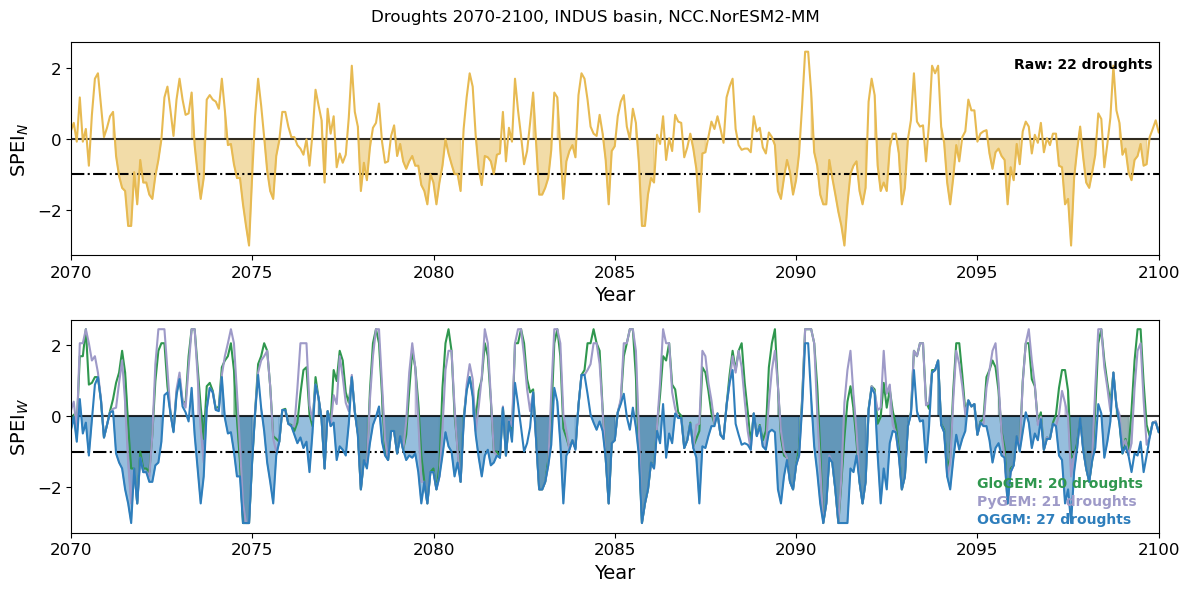

In [37]:
example_basin='INDUS'
example_model=modelnames_provis[4]
example_series_n = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['NRunoff'][example_model]
example_series_w_glogem = SPEI_basin_sorted_GEM['GloGEM'][example_basin]['WRunoff'][example_model]
example_series_w_pygem = SPEI_basin_sorted_GEM['PyGEM'][example_basin]['WRunoff'][example_model]
example_series_w_oggm = SPEI_basin_sorted_GEM['OGGM'][example_basin]['WRunoff'][example_model]


example_color_n=cm.get_cmap('tab20b')(10)
example_color_w_glogem=cm.get_cmap(colormaps_w['GloGEM'])(0.7)
example_color_w_pygem=cm.get_cmap(colormaps_w['PyGEM'])(0.5)
example_color_w_oggm=cm.get_cmap(colormaps_w['OGGM'])(0.7)


droughts_n = gSPEI.find_droughts(example_series_n, threshold=-1, 
                               period=example_period)
drought_mask_n = np.full(np.shape(yrs), fill_value=False)
for k in droughts_n.keys():
    for n in range(k-len(droughts_n[k]), k+1):
        drought_mask_n[n] = True
        
droughts_w_glogem = gSPEI.find_droughts(example_series_w_glogem, threshold=-1, 
                               period=example_period)
drought_mask_w_glogem = np.full(np.shape(yrs), fill_value=False)
for k in droughts_w_glogem.keys():
    for n in range(k-len(droughts_w_glogem[k]), k+1):
        drought_mask_w_glogem[n] = True

droughts_w_pygem = gSPEI.find_droughts(example_series_w_pygem, threshold=-1, 
                               period=example_period)
drought_mask_w_pygem = np.full(np.shape(yrs), fill_value=False)
for k in droughts_w_pygem.keys():
    for n in range(k-len(droughts_w_pygem[k]), k+1):
        drought_mask_w_pygem[n] = True

droughts_w_oggm = gSPEI.find_droughts(example_series_w_oggm, threshold=-1, 
                               period=example_period)
drought_mask_w_oggm = np.full(np.shape(yrs), fill_value=False)
for k in droughts_w_oggm.keys():
    for n in range(k-len(droughts_w_oggm[k]), k+1):
        drought_mask_w_oggm[n] = True
        
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,6), tight_layout=True)
ax1.axhline(y=0, color='k', alpha=0.8)
ax1.axhline(y=-1, ls='-.', color='k')
ax1.plot(yrs, example_series_n, color=example_color_n)
ax1.fill_between(yrs, y1=0, y2=example_series_n, where=drought_mask_n, 
                alpha=0.5, color=example_color_n)
ax1.annotate('Raw: {} droughts'.format(len(droughts_n)), xy=(2096,2.0),
            fontweight='bold')
ax1.set(xlim=example_period, yticks=(-2, 0, 2))
ax1.tick_params(axis='both', labelsize=12)
ax1.set_xlabel('Year', fontsize=14)
ax1.set_ylabel(r'SPEI$_N$', fontsize=14)


ax2.axhline(y=0, color='k', alpha=0.8)
ax2.axhline(y=-1, ls='-.', color='k')
## plot GloGEM
ax2.plot(yrs, example_series_w_glogem, color=example_color_w_glogem)
ax2.fill_between(yrs, y1=0, y2=example_series_w_glogem, where=drought_mask_w_glogem, 
                alpha=0.5, color=example_color_w_glogem)
ax2.annotate('GloGEM: {} droughts'.format(len(droughts_w_glogem)), xy=(2095,-2.0),
            fontweight='bold', color=example_color_w_glogem)
## plot PyGEM
ax2.plot(yrs, example_series_w_pygem, color=example_color_w_pygem)
ax2.fill_between(yrs, y1=0, y2=example_series_w_pygem, where=drought_mask_w_pygem, 
                alpha=0.5, color=example_color_w_pygem)
ax2.annotate('PyGEM: {} droughts'.format(len(droughts_w_pygem)), xy=(2095,-2.5),
            fontweight='bold', color=example_color_w_pygem)
## plot OGGM
ax2.plot(yrs, example_series_w_oggm, color=example_color_w_oggm)
ax2.fill_between(yrs, y1=0, y2=example_series_w_oggm, where=drought_mask_w_oggm, 
                alpha=0.5, color=example_color_w_oggm)
ax2.annotate('OGGM: {} droughts'.format(len(droughts_w_oggm)), xy=(2095,-3.0),
            fontweight='bold', color=example_color_w_oggm)

ax2.set(xlim=example_period, yticks=(-2,0,2))
ax2.tick_params(axis='both', labelsize=12)
ax2.set_xlabel('Year', fontsize=14)
ax2.set_ylabel(r'SPEI$_W$', fontsize=14)
fig.suptitle('Droughts 2070-2100, {} basin, {}'.format(example_basin, example_model))
plt.show()


Plot a single model rolling-mean series, separated by glacier model, so we can better see what's going on.

GloGEM
PyGEM
OGGM


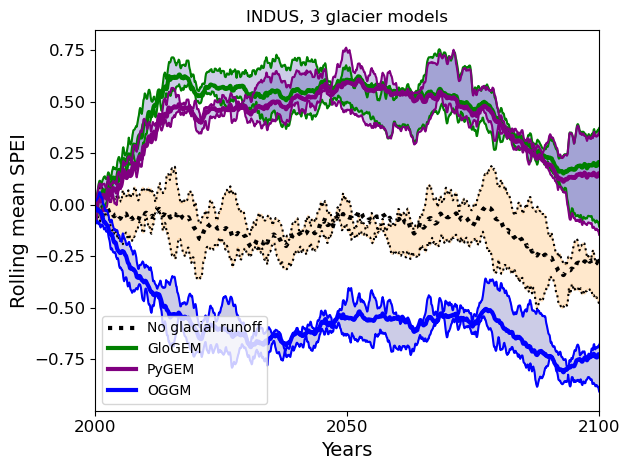

In [51]:
## Compute multi-GCM ensemble means and quartiles
## Use colors set above
# example_color_w_glogem=cm.get_cmap(colormaps_w['GloGEM'])(0.7)
# example_color_w_pygem=cm.get_cmap(colormaps_w['PyGEM'])(1.0)
# example_color_w_oggm=cm.get_cmap(colormaps_w['OGGM'])(0.7)

example_color_w_glogem='Green'
example_color_w_pygem='Purple'
example_color_w_oggm='Blue'

example_colors_w = {'GloGEM': example_color_w_glogem,
                    'PyGEM': example_color_w_pygem,
                    'OGGM': example_color_w_oggm}


fig, ax = plt.subplots()
for g in gmodels:
    example_GEM = g
    print(g)
    # colors_w = cm.get_cmap(colormaps_w[g])(np.linspace(0.2, 1, num=len(modelnames_provis)))
    r_w = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'WRunoff').rolling(window=12*win).mean()
    r_n = gSPEI.basin_ensemble_mean(SPEI_basin_sorted_GEM[example_GEM], example_b, 'NRunoff').rolling(window=12*win).mean()
    rm = SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1 = rm.quantile(q=0.25, axis=1)
    rm_q3 = rm.quantile(q=0.75, axis=1)
    rm_n = SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'].rolling(window=12*win, axis=0).mean()
    rm_q1_n = rm_n.quantile(q=0.25, axis=1)
    rm_q3_n = rm_n.quantile(q=0.75, axis=1)
    # rm_q1_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.25, axis=1)
    # rm_q3_n = SPEI_by_basin[example_b]['NRunoff'].rolling(window=12*30, axis=0).quantile(quantile=0.75, axis=1)

    single_models_w = [SPEI_basin_sorted_GEM[example_GEM][example_b]['WRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]
    single_models_n = [SPEI_basin_sorted_GEM[example_GEM][example_b]['NRunoff'][m].rolling(window=12*win).mean() for m in modelnames_provis]

    if g == 'GloGEM': ## plot these only once, as they should all be the same
        ax.plot(yrs, r_n, 'k', linewidth=3.0, ls=':', label='No glacial runoff')
        ax.plot(yrs, rm_q1_n, 'k', ls=':')
        ax.plot(yrs, rm_q3_n, 'k', ls=':')
        ax.fill_between(yrs, rm_q1_n, rm_q3_n, color='DarkOrange', alpha=0.2)

    # ax.plot(yrs, r_w, 'k', linewidth=3.0)
    # ax.plot(yrs, rm_q1, 'k')
    # ax.plot(yrs, rm_q3, 'k')
    ax.plot(yrs, r_w, example_colors_w[g], linewidth=3.0, label=g) ## Tried to plot color-coding by GEM, but it looks weird.
    ax.plot(yrs, rm_q1, example_colors_w[g])
    ax.plot(yrs, rm_q3, example_colors_w[g])
    ax.fill_between(yrs, rm_q1, rm_q3, color='DarkBlue', alpha=0.2)
    # if plot_single_models:
    #     for i in range(len(modelnames_provis)):
    #         ax.plot(yrs, single_models_w[i], color=colors_w[i], alpha=0.5)
    #         ax.plot(yrs, single_models_n[i], color=colors_n[i], alpha=0.5)
ax.tick_params(axis='both', labelsize=12)
ax.set_xticks([2000, 2050, 2100])
ax.set_xlim(2000, 2100)
ax.set_xlabel('Years', fontsize=14)
ax.set_ylabel('Rolling mean SPEI', fontsize=14)
ax.set(title='{}, 3 glacier models'.format(example_b))
ax.legend(loc='best')
plt.tight_layout()

Found and fixed a small bug in the above: needed to plot quantiles with `SPEI_basin_sorted_GEM[example_GEM][example_b][case]` rather than `SPEI_by_basin[example_b][case]`.  Need to return to multi-basin plot above to fix this.